<a href="https://colab.research.google.com/github/ranitha84/gesture_recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images). 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

## Importing necessary libraries

In [3]:
import numpy as np
import os
import datetime
import cv2


In [4]:
np.random.seed(30)
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D,ZeroPadding3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


rn.seed(30)
tf.random.set_seed(30)

In [5]:
drive_path = '/content/Project_data'

train_doc = np.random.permutation(open(drive_path+'/train.csv').readlines())
val_doc = np.random.permutation(open(drive_path+'/val.csv').readlines())

train_path = drive_path+'/train'
val_path = drive_path+'/val'

batch_size = 10

image_width = 100
image_height = 100

# Generator 
- The generator yields the batch data and labels based on the batch size provided.

In [6]:

class AugmentedDataGenerator:

  def __init__(self, width=image_width, height=image_height, frames=30, channels=3,number_samples=20,num_classes=5,  augment=False, rotate=False):
    self.width= width
    self.height = height
    self.frames = 30
    self.channels = channels
    self.augment = augment
    self.number_samples = number_samples
    self.num_classes = num_classes
    self.rotate= rotate

  def __resize(self, image):
    return cv2.resize(image, (self.height,self.width), interpolation = cv2.INTER_AREA)

  def __normalize(self,image):
    return image/255

  def __augment(self,image):
    # shift image 
    shifted = cv2.warpAffine(image, 
                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                             (image.shape[1], image.shape[0]))
                  
    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

    x0, y0 = np.argwhere(gray > 0).min(axis=0)
    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
    
    # crop image
    cropped=shifted[x0:x1,y0:y1,:]

    image_resized=self.__resize(cropped)
    
    # rotate image
    if self.rotate:
      M = cv2.getRotationMatrix2D((self.width//2,self.height//2),
                                  np.random.randint(-10,10), 1.0)
      image_resized = cv2.warpAffine(image_resized, M, (self.width, self.height))

    return image_resized

  def yield_batches(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
      seq_len = remaining_seq if remaining_seq else batch_size
      
      batch_data = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels)) 
      batch_labels = np.zeros((seq_len,self.num_classes)) 

      if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels))

      
      for folder in range(seq_len): 
          imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
          for idx,item in enumerate(img_idx): 
              # read image
              image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_COLOR)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

              # resize image
              image_resized=self.__resize(image)
          
              # normalize image
              batch_data[folder,idx,:,:,0] = self.__normalize(image_resized[:,:,0])
              batch_data[folder,idx,:,:,1] = self.__normalize(image_resized[:,:,1])
              batch_data[folder,idx,:,:,2] = self.__normalize(image_resized[:,:,2])

              # augmented image
              if (self.augment):
                  
                  image_augmented = self.__augment(image) 
                  
                  batch_data_aug[folder,idx,:,:,0] = self.__normalize(image_augmented[:,:,0])
                  batch_data_aug[folder,idx,:,:,1] = self.__normalize(image_augmented[:,:,1])
                  batch_data_aug[folder,idx,:,:,2] = self.__normalize(image_augmented[:,:,2])
              
          
          batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          

      if (self.augment):
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])

      
      return (batch_data,batch_labels)

  def generator(self, source_path, folder_list, batch_size):
    img_idx = np.round(np.linspace(0,self.frames-1,self.number_samples)).astype(int)
    print( 'Source path = ', source_path, '; batch size =', batch_size,'; Image samples = ',img_idx)
    
    batch_size=batch_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        remaining_seq = len(t)%batch_size

        for batch in range(num_batches): 
            batch_data, batch_labels= self.yield_batches(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels 

        
        if (len(t)%batch_size):
            batch_data, batch_labels= self.yield_batches(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels 
    

# Plot

- The method helps to plot the training and validation losses and accuracies respectively.
- A generic method is written to plot the accuracies and losses after each model run

In [7]:
import matplotlib.pyplot as plt # for plotting


def plot_accuracy(history):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.show() 

# Training model
- Generic method which takes in train and validation generator, batch size and the number of epochs the model should run

- Optimizer used for the entire model run is **Adam**

- **Categorical Cross  entropy and Categorical accuracy** are being used for losses and accuracy respectively

In [37]:
def train_model( model, batch_size, num_epochs, train_generator, val_generator,learning_rate=0.01, early_stopping=False):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)
    print ('learning_rate =', learning_rate)


    print('Number of epochs {}'.format(num_epochs))
    print('Batch Size {}'.format(batch_size))
    print('Current Date time {}'.format(curr_dt_time))

    # Defining call back lists

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=2, verbose=1,mode='auto')

    callbacks_list = [checkpoint, LR]

    if early_stopping:
      ER = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1)
      callbacks_list.append(ER)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
   
    if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history = model.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator, 
              validation_steps=validation_steps, 
              class_weight=None, 
              initial_epoch=0,
              workers=1)
    plot_accuracy(history)
    K.clear_session()

# Model Generator
- This can takes in the input shape as parameter
- Differnt models to be built are part of this class and used for generating models and training them respectively

In [41]:

from keras.applications import ResNet50V2, VGG16, mobilenet

class ModelGenerator():

  def __init__(self,input_shape=(30, image_height,image_width,3), num_classes=5):
    self.input_shape= input_shape
    self.num_classes = num_classes

  
  def model_cv3D(self,dropout=0.25):

      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(128, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Flatten())
      model.add(Dense(128,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model
  
  def model_cv3D2(self,dropout=0.25):
      '''
        Additional layers have been added to the the Conv3D with 2*2*2 filter
      '''
      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(16, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      

      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_cv3D3(self,dropout=0.25):
      '''
      Additional layers have been added and dropouts added to the the Conv3D with 2*2*2 filter
      '''
      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(16, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))
      

      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_cv3D4(self,dropout=0.25):
      '''
        Reduced number of parameters
      '''
      model = Sequential()
      model.add(Conv3D(8, (3, 3, 3), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(16, (3, 3, 3), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      
      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_lstm(self, dropout=0.25):
      '''
        LSTM model
      '''
      model = Sequential()

      model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                input_shape=self.input_shape))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      

      model.add(TimeDistributed(Flatten()))


      model.add(LSTM(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  
  def model_gru(self, dropout=0.25):
    '''
      GRU Model
    '''
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=self.input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    

    model.add(TimeDistributed(Flatten()))


    model.add(GRU(128))
    model.add(Dropout(dropout))
    
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(self.num_classes, activation='softmax'))

    return model

  
  def model_vgg16_gru(self,dropout=0.25):
      '''
        Transfer learning with VGG16 
      '''
      vgg16 = VGG16(weights='imagenet', include_top=False)

      model = Sequential()
      model.add(TimeDistributed(vgg16,input_shape=self.input_shape))
      
      
      for layer in model.layers:
          layer.trainable = False
      
      
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      model.add(TimeDistributed(Flatten()))

      model.add(GRU(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  
  def model_resnet_gru(self,dropout=0.25):
      '''
        Transfer learning with Mobilenet 
      '''
      resnet_m = ResNet50V2(weights='imagenet', include_top=False)

      model = Sequential()
      model.add(TimeDistributed(resnet_m,input_shape=self.input_shape))
      
      
      for layer in model.layers:
          layer.trainable = False
      
      
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      model.add(TimeDistributed(Flatten()))

      model.add(GRU(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  def model_mobilenet_gru(self,dropout=0.25):
      '''
        Transfer learning with Mobilenet 
      '''
      mobilenet_m = mobilenet.MobileNet(weights='imagenet', include_top=False)

      model = Sequential()
      model.add(TimeDistributed(mobilenet_m,input_shape=self.input_shape))
      
      
      for layer in model.layers:
          layer.trainable = False
      
      
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      model.add(TimeDistributed(Flatten()))

      model.add(GRU(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

## Testing with differnt hyper parameters before proceeding with actual model building

#### Sampling with 20 frames from each video and batch size as 20 and number of epochs run is 3 

# training sequences = 663
# validation sequences = 100
# epochs = 3
Number of epochs 3
Batch Size 20
Current Date time 2021-02-28 16:16:25.089200
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 5

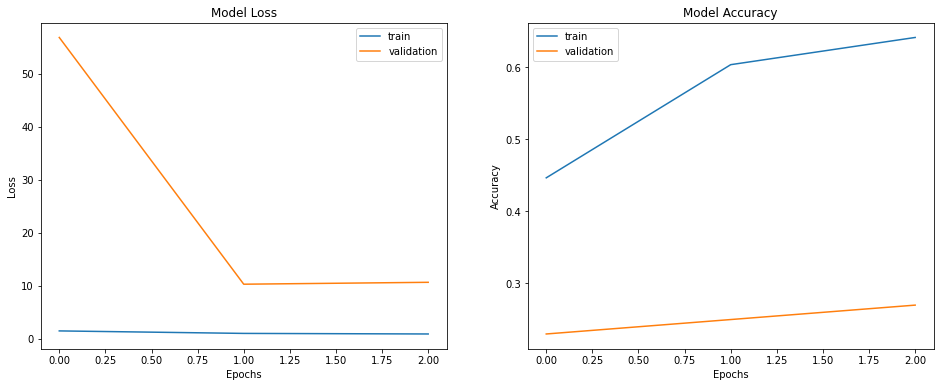

In [11]:
train_gen = AugmentedDataGenerator()
val_gen = AugmentedDataGenerator()

batch_size = 20
num_epochs =3

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(20,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

#### Sampling with 16 frames, batch size as 30 and number of epoch is 3

# training sequences = 663
# validation sequences = 100
# epochs = 3
Number of epochs 3
Batch Size 30
Current Date time 2021-03-01 01:41:35.638534
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50

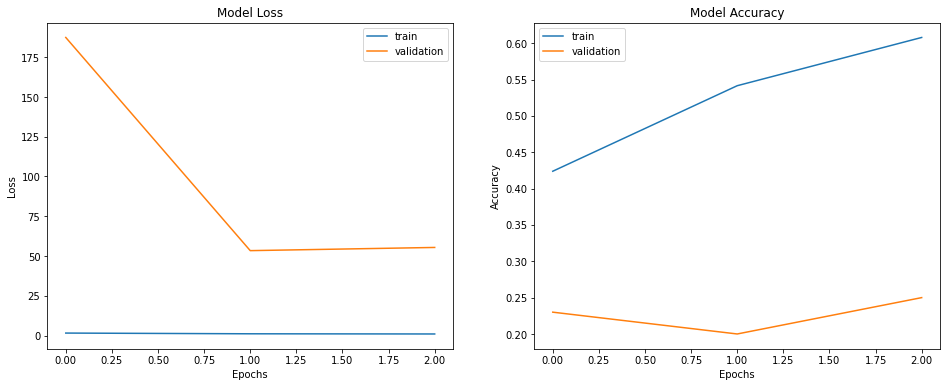

In [14]:
batch_size = 30
num_epochs =3
frames_sample=16

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# Hyperparameters considered for training the models

We see a considerable increase on speed of the training the model with increase in batch. But with reduction in  number of frames, we see a slight drop in the valdiation accuracy. 
The following hyper parameters are considered to train the rest of the model
- Frame sample - 20
- Batch Size - 40
- Number of epochs - 25


# Model # 1 
## Conv3D without augmentation


# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-03-01 01:47:04.476747
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10,

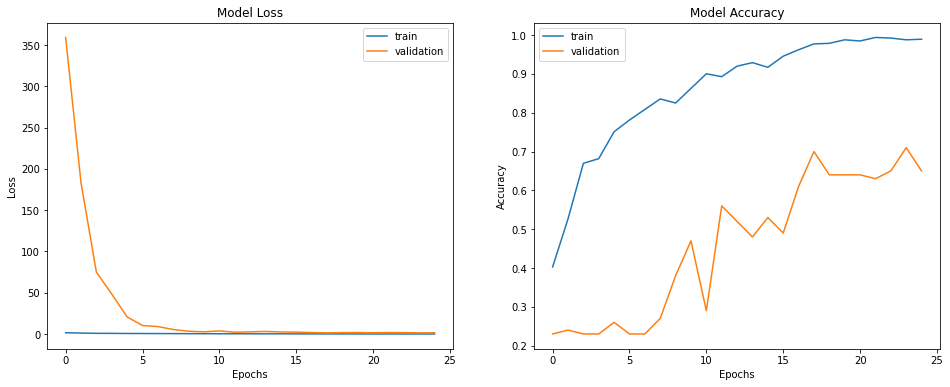

In [15]:
frames_sample=20
batch_size=40
num_epochs=25

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**</mark> We see the model over fits in our case. Lets try to augment the dataset and see whether there is any improvement in the overall validation accuracy

# Model 1 - With augmentation 

# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-02-28 16:29:29.734672
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 1

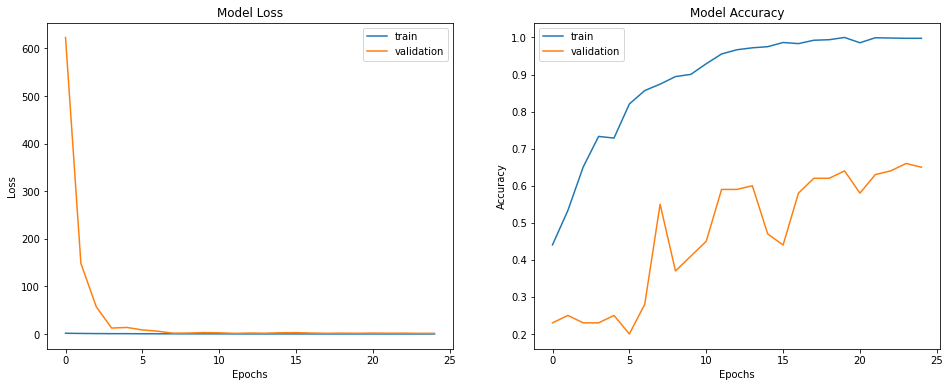

In [16]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> Still the model is overfitting. Lets try to add additional conv3d layers and see whether we see improvement in the validation accuracy

## Model 2 - Additional Layers and without augmentation


# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-03-01 02:10:31.939024
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20,

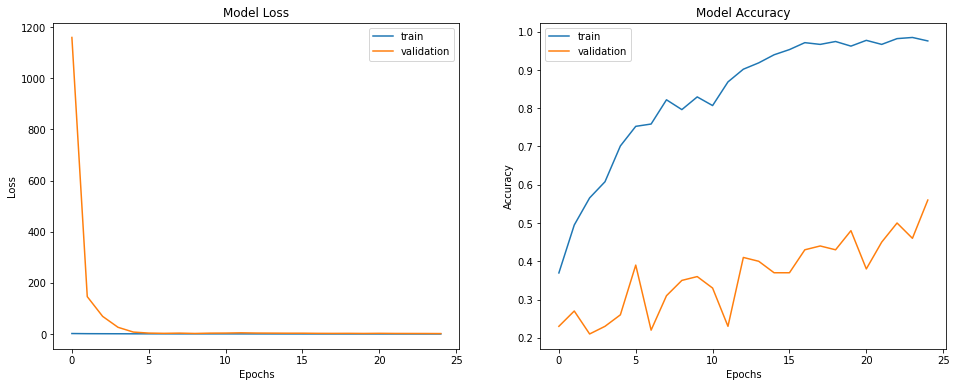

In [21]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D2()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

## Model 2 - Additional Layers and with augmentation


# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-03-01 02:25:51.396438
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20,

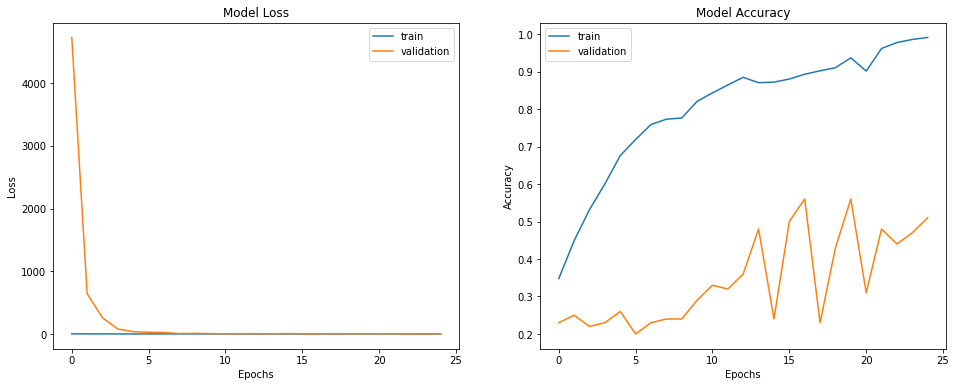

In [22]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample, augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D2()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> Still the model is overfitting. Lets try to add additional conv3d layers and see whether we see improvement in the validation accuracy

## Model 3 - Additional Layers and added Dropout to CNN layer and without augmentation

# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-03-01 03:20:00.153241
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20,

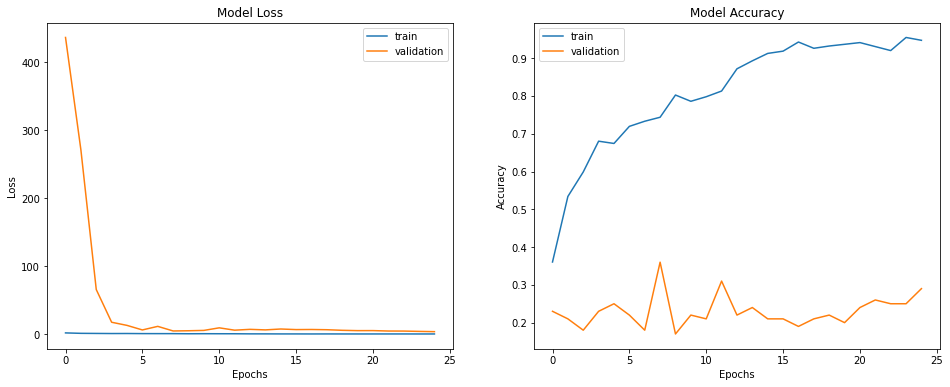

In [25]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D3()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# Model 3 with Augmentation and Early Stopping
- We are trying to run more number of epochs to see whether there is any  improvement in model validation accuracy. In order to save computational resources, we have enabled Early stopping with patience as 10



# training sequences = 663
# validation sequences = 100
# epochs = 100
Number of epochs 100
Batch Size 40
Current Date time 2021-03-01 04:04:11.281784
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2

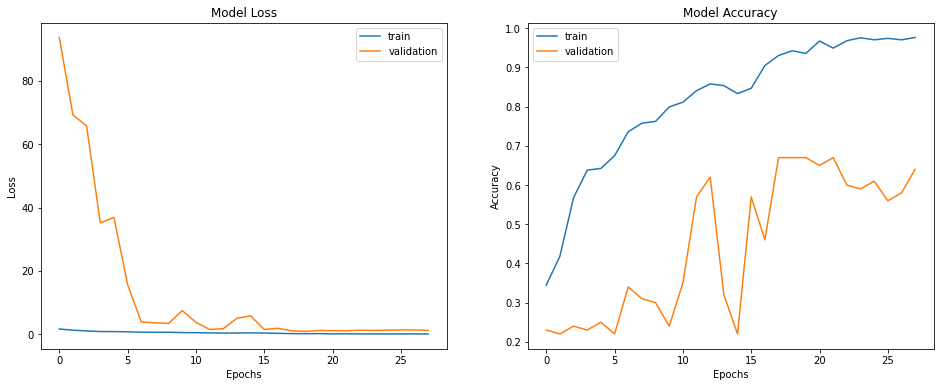

In [28]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D3()

train_model(model=model,batch_size=batch_size,num_epochs=100,train_generator=train_generator,val_generator=val_generator,early_stopping=True)

# Model 4 with image width and height as 120 and reduced parameters

#### Running 50 Epochs with a batch size of 30 and sample size of 20


# training sequences = 663
# validation sequences = 100
# epochs = 50
Number of epochs 50
Batch Size 30
Current Date time 2021-03-02 01:44:27.621776
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation_4 (Activation)    (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_5 (Activation)    (None, 1

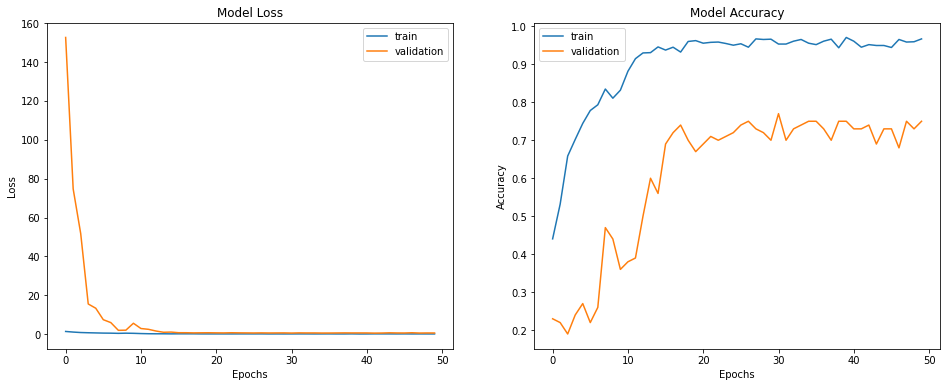

In [13]:
batch_size = 30
num_epochs = 50
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

We still see over fitting. Lets try to augment the image by adding additional rotation to the images

# Model 4 with image width and height as 120 and reduced parameters

#### Running 20 Epochs with a batch size of 30 and sample size of 20

#### Augmenting the images with additional rotation

# training sequences = 663
# validation sequences = 100
# epochs = 30
Number of epochs 30
Batch Size 30
Current Date time 2021-03-02 03:08:45.602065
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation_4 (Activation)    (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_5 (Activation)    (None, 1

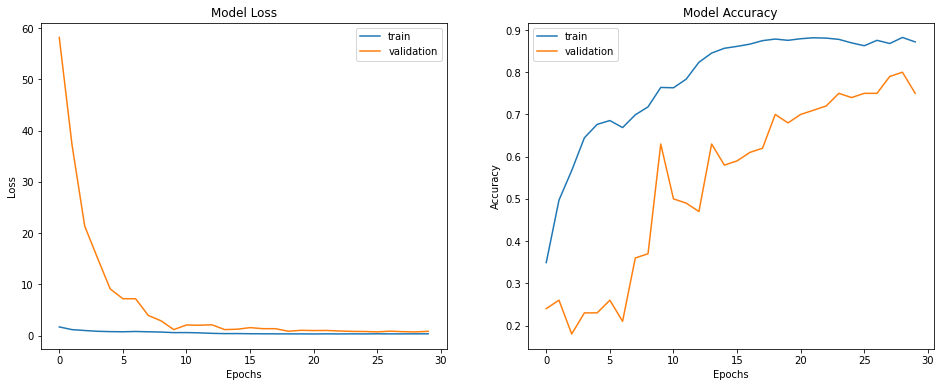

In [19]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

Though we see the model overfitting we see considerable improvement in the model. Lets try with other models using the above configuration to see whether the validationa and training accuracy improves or not


# Model 5 LSTM model with image size as 120 
#### Training has been augmented and rotated
- No.of Samples -20
- Batch Size - 30
- No.of Epochs - 25

# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 30
Current Date time 2021-03-02 04:00:07.200278
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20,

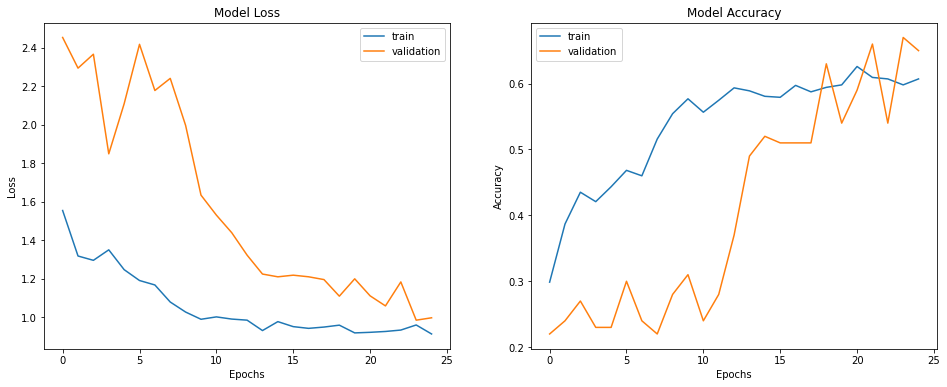

In [20]:
batch_size = 30
num_epochs = 25
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_lstm()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)


# Model 6 GRU model with image size as 120 
#### Training has been augmented and rotated
- No.of Samples -20
- Batch Size - 30
- No.of Epochs - 60
- Early stopping enabled on validation accuracy

# training sequences = 663
# validation sequences = 100
# epochs = 60
Number of epochs 60
Batch Size 30
Current Date time 2021-03-02 09:17:43.567389
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20,

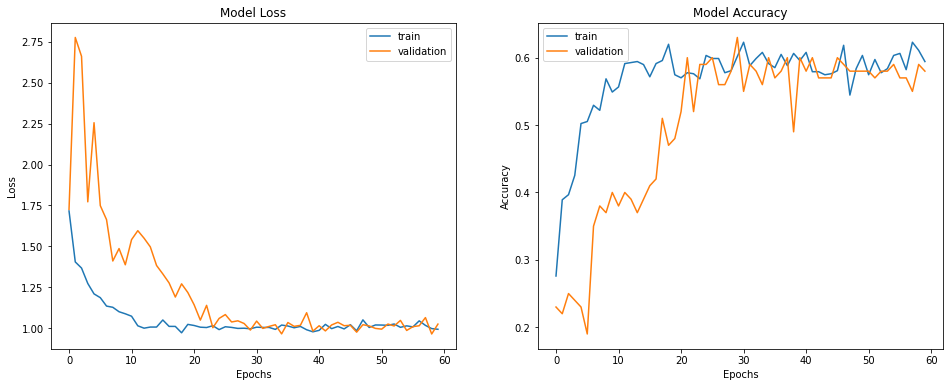

In [11]:
batch_size = 30
num_epochs = 60
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_gru()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# training sequences = 663
# validation sequences = 100
# epochs = 60
Number of epochs 60
Batch Size 30
Current Date time 2021-03-02 04:33:59.777306
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2

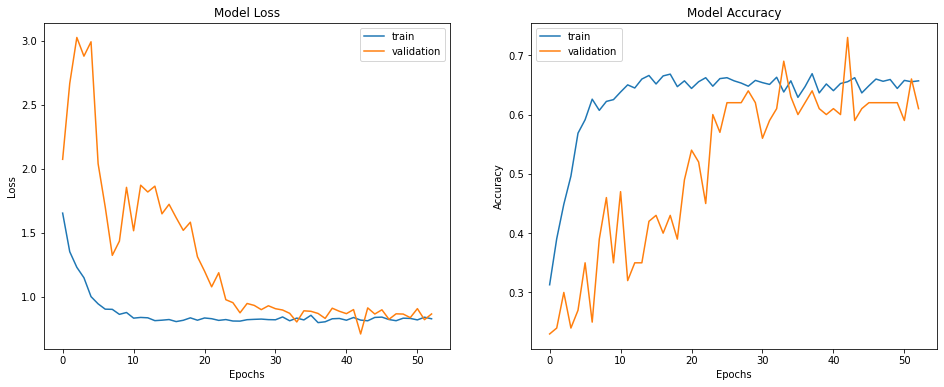

In [29]:
batch_size = 30
num_epochs = 60
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_gru()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator,early_stopping=True)

# Final Best Model 


# training sequences = 663
# validation sequences = 100
# epochs = 30
Number of epochs 30
Batch Size 30
Current Date time 2021-03-04 05:09:10.981465
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Activation)    (None, 10,

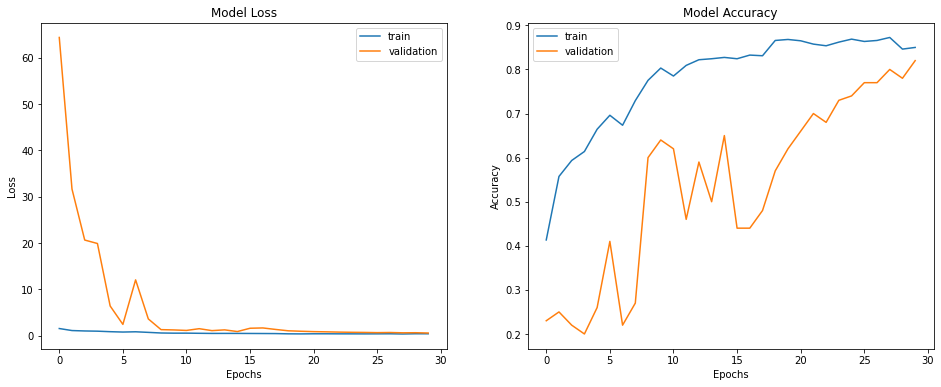

In [38]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# training sequences = 663
# validation sequences = 100
# epochs = 30
Number of epochs 30
Batch Size 30
Current Date time 2021-03-04 06:45:20.069114
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Activation)    (None, 10,

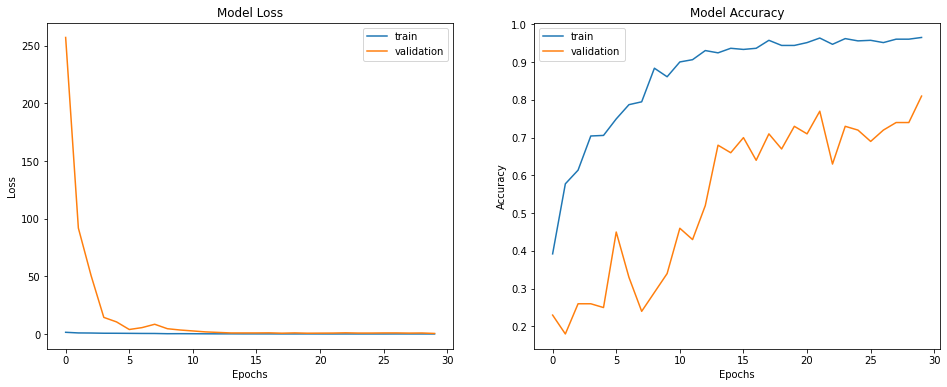

In [42]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)